

# TODO:   

* Read https://pandas.pydata.org/pandas-docs/dev/getting_started/intro_tutorials/09_timeseries.html completely. 
    Then maybe refactor some of this to use timestamps as indexes.
* in either pandas or sqlite, convert UTC to local time for the load dataframe

* rename "load" to "demand" to reduce confusion


## Get SPP Hourly Load data.  


In [1]:
import urllib.request
import os

downloads_dir = 'downloads/'
years_to_load = ['2015', '2016', '2017', '2018', '2019']

sourceurl = 'ftp://pubftp.spp.org/Operational_Data/HourlyLoad/%s/%s.zip'

for year in years_to_load:
    if os.path.exists(downloads_dir + year + '.zip') == False: 
        print ("Trying to retrieve hourly demand for " + year, end=' ... ', flush=True)
        urllib.request.urlretrieve(sourceurl%(year, year), downloads_dir + year + ".zip")
        print ("done")
    else:
        print (downloads_dir + year + ".zip already downloaded")


downloads/2015.zip already downloaded
downloads/2016.zip already downloaded
downloads/2017.zip already downloaded
downloads/2018.zip already downloaded
downloads/2019.zip already downloaded


In [2]:
from zipfile import ZipFile
import pandas as pd
import numpy as np
import io

try: 
    del demand_df
except: 
    pass

for year in years_to_load:
    with ZipFile(downloads_dir + year + '.zip', 'r') as zipObj:
        # Get list of files names in zip
        listOfiles = zipObj.namelist()
        # Iterate over the list of file names in given list & print them
        for elem in listOfiles:
#            print(elem)
            if (elem.split('.')[-1:][0] == 'csv'):
                df = pd.read_csv(io.BytesIO( zipObj.read(elem)) ) 
                try: 
                    demand_df = demand_df.append(df)
                except: 
                    demand_df = df

demand_df = demand_df.reset_index(drop=True)
demand_df.head()

,MarketHour,CSWS,EDE,GRDA,INDN,KACY,KCPL,LES,MPS,NPPD,OKGE,OPPD,SECI,SPRM,SPS,WFEC,WR,WAUE
0,7/1/2015 6:00,5764.911333,596.281417,799.847667,123.030083,296.929250,1949.042000,372.480333,1018.514250,2219.108833,4117.08400,1258.544250,887.502083,395.434000,3920.596000,1111.297750,3961.901250,NaN
1,7/1/2015 7:00,5412.822750,564.420333,822.521167,108.127000,280.323917,1801.828333,348.362333,961.898000,2123.033417,3873.73125,1184.703333,845.620500,371.291667,3786.391167,1065.715000,3744.169250,NaN
2,7/1/2015 8:00,5159.626583,545.948917,807.133917,98.328583,270.348250,1666.008583,329.306750,896.261500,2046.187250,3706.41750,1140.597083,812.216833,356.816583,3694.294667,1032.225750,3591.133583,NaN
3,7/1/2015 9:00,4995.453167,534.070417,798.911667,96.420667,262.933333,1607.743750,323.767583,868.995833,1994.560333,3578.15025,1115.101833,792.190417,347.746083,3631.846917,1008.360917,3487.656750,NaN
4,7/1/2015 10:00,4936.187167,538.574083,797.087083,95.493000,261.330417,1608.171667,325.644667,866.115250,1999.117083,3511.46950,1127.351583,784.963750,351.444917,3601.413083,986.151417,3465.577667,NaN


In [3]:
# Yikes, all my column names start with spaces. Fix that real quick:
renamedict={}
for i in demand_df.columns: 
    if i.startswith(' '):
        renamedict[i] = i[1:]
demand_df.rename(columns=renamedict, inplace=True)
demand_df.columns

Index(['MarketHour', 'CSWS', 'EDE', 'GRDA', 'INDN', 'KACY', 'KCPL', 'LES',
       'MPS', 'NPPD', 'OKGE', 'OPPD', 'SECI', 'SPRM', 'SPS', 'WFEC', 'WR',
       'WAUE'],
      dtype='object')

In [4]:
demand_df.count()

MarketHour    46342
CSWS          46335
EDE           46335
GRDA          46342
INDN          46335
KACY          46335
KCPL          46335
LES           46335
MPS           46335
NPPD          46342
OKGE          46335
OPPD          46335
SECI          46335
SPRM          46335
SPS           46335
WFEC          46335
WR            46335
WAUE          39784
dtype: int64

In [5]:
# drop rows where MarketHour is all blanks (https://stackoverflow.com/questions/29314033/drop-rows-containing-empty-cells-from-a-pandas-dataframe)

demand_df['MarketHour'].replace('', np.nan, inplace=True)
demand_df.dropna(subset=['MarketHour'], inplace=True)
demand_df.count()

# also there are a handful of bad rows where CSWS and others are blank
demand_df['CSWS'].replace('', np.nan, inplace=True)
demand_df.dropna(subset=['CSWS'], inplace=True)
demand_df.count()


MarketHour    46335
CSWS          46335
EDE           46335
GRDA          46335
INDN          46335
KACY          46335
KCPL          46335
LES           46335
MPS           46335
NPPD          46335
OKGE          46335
OPPD          46335
SECI          46335
SPRM          46335
SPS           46335
WFEC          46335
WR            46335
WAUE          39784
dtype: int64

## What is the last MarketHour really?  And what is that silly time format? 

I am amzaed; I have spent weeks of my life dealing with bad timestamp formats and this one line of code fixes them

In [6]:
pd.to_datetime(['2021-09-01 17:00', '16-Jul-1970 3:30PM', '9/11/2001 8:46AM', '3/4/5 6:7' ])
# wow.

DatetimeIndex(['2021-09-01 17:00:00', '1970-07-16 15:30:00',
               '2001-09-11 08:46:00', '2005-03-04 06:07:00'],
              dtype='datetime64[ns]', freq=None)

In [7]:
demand_df['MarketHour'] = pd.to_datetime(demand_df.MarketHour)

In [8]:
demand_df.sort_values(by='MarketHour', inplace=True, ignore_index=True)
demand_df.tail()

,MarketHour,CSWS,EDE,GRDA,INDN,KACY,KCPL,LES,MPS,NPPD,OKGE,OPPD,SECI,SPRM,SPS,WFEC,WR,WAUE
46330,2020-01-01 04:00:00,5545.088,630.389,615.696,113.786,249.791,1676.336,382.204,994.151,1933.474,3751.846,1313.509,675.244,347.436,3698.425,1180.288,3313.351,3870.478
46331,2020-01-01 05:00:00,5458.283,618.698,659.819,108.714,240.306,1620.266,363.335,967.530,1871.545,3699.653,1268.479,691.024,334.990,3662.115,1174.091,3259.097,3781.432
46332,2020-01-01 05:00:00,5458.283,618.698,659.819,108.714,240.306,1620.266,363.335,967.530,1871.545,3699.653,1268.479,691.024,334.990,3662.115,1174.091,3259.097,3781.432
46333,2020-01-01 06:00:00,5375.829,608.699,653.098,105.863,236.105,1566.098,350.420,946.561,1845.086,3625.135,1229.562,680.744,324.372,3626.091,1164.288,3202.171,3714.911
46334,2020-01-01 06:00:00,5375.829,608.699,653.098,105.863,236.105,1566.098,350.420,946.561,1845.086,3625.135,1229.562,680.744,324.372,3626.091,1164.288,3202.171,3714.911


## MarketHour is in an industry format known as Hour Ending GMT.
So the load reported for 2020-01-01 06:00:00 is summed over the last hour of 2019, which ends at the start of the first hour of 2020.  This is an inconvenient format because grouping to a higher time level like day or month is difficult. So, I want to subtract an hour from each MarketHour and call it HourBeginUTC so we are all clear on what it means, and all the hours for a given day match that day. 

In [9]:
demand_df.MarketHour -= pd.Timedelta("1 hour")
demand_df.rename(columns={"MarketHour":"HourBeginUTC"}, inplace=True)

# Convert UTC to US/Central
# OMG this is an ugly hack please refactor correctly
demand_df['HourBeginCPT']=demand_df.HourBeginUTC.dt.tz_localize('utc').dt.tz_convert('US/Central')
demand_df.tail()

,HourBeginUTC,CSWS,EDE,GRDA,INDN,KACY,KCPL,LES,MPS,NPPD,OKGE,OPPD,SECI,SPRM,SPS,WFEC,WR,WAUE,HourBeginCPT
46330,2020-01-01 03:00:00,5545.088,630.389,615.696,113.786,249.791,1676.336,382.204,994.151,1933.474,3751.846,1313.509,675.244,347.436,3698.425,1180.288,3313.351,3870.478,2019-12-31 21:00:00-06:00
46331,2020-01-01 04:00:00,5458.283,618.698,659.819,108.714,240.306,1620.266,363.335,967.530,1871.545,3699.653,1268.479,691.024,334.990,3662.115,1174.091,3259.097,3781.432,2019-12-31 22:00:00-06:00
46332,2020-01-01 04:00:00,5458.283,618.698,659.819,108.714,240.306,1620.266,363.335,967.530,1871.545,3699.653,1268.479,691.024,334.990,3662.115,1174.091,3259.097,3781.432,2019-12-31 22:00:00-06:00
46333,2020-01-01 05:00:00,5375.829,608.699,653.098,105.863,236.105,1566.098,350.420,946.561,1845.086,3625.135,1229.562,680.744,324.372,3626.091,1164.288,3202.171,3714.911,2019-12-31 23:00:00-06:00
46334,2020-01-01 05:00:00,5375.829,608.699,653.098,105.863,236.105,1566.098,350.420,946.561,1845.086,3625.135,1229.562,680.744,324.372,3626.091,1164.288,3202.171,3714.911,2019-12-31 23:00:00-06:00


## I see some duplicate rows, due to the way the files are stored on the source site.

De-duplicate: 

In [10]:
 
demand_df.drop_duplicates(subset='HourBeginUTC', keep='first', ignore_index=True, inplace=True)
demand_df.tail()

,HourBeginUTC,CSWS,EDE,GRDA,INDN,KACY,KCPL,LES,MPS,NPPD,OKGE,OPPD,SECI,SPRM,SPS,WFEC,WR,WAUE,HourBeginCPT
43809,2020-01-01 01:00:00,5577.976,642.424,620.169,122.165,261.041,1844.867,403.365,1036.075,1990.111,3764.081,1378.452,655.260,366.549,3709.873,1173.041,3408.587,4006.754,2019-12-31 19:00:00-06:00
43810,2020-01-01 02:00:00,5592.408,637.974,617.084,117.503,255.755,1729.733,393.802,1015.739,1971.021,3790.055,1347.326,659.367,357.205,3713.646,1182.855,3358.233,3954.821,2019-12-31 20:00:00-06:00
43811,2020-01-01 03:00:00,5545.088,630.389,615.696,113.786,249.791,1676.336,382.204,994.151,1933.474,3751.846,1313.509,675.244,347.436,3698.425,1180.288,3313.351,3870.478,2019-12-31 21:00:00-06:00
43812,2020-01-01 04:00:00,5458.283,618.698,659.819,108.714,240.306,1620.266,363.335,967.530,1871.545,3699.653,1268.479,691.024,334.990,3662.115,1174.091,3259.097,3781.432,2019-12-31 22:00:00-06:00
43813,2020-01-01 05:00:00,5375.829,608.699,653.098,105.863,236.105,1566.098,350.420,946.561,1845.086,3625.135,1229.562,680.744,324.372,3626.091,1164.288,3202.171,3714.911,2019-12-31 23:00:00-06:00


In [11]:
print ("Expecting 5 years of hours, or about ", 365.25*5*24, "observations")
demand_df.count()

Expecting 5 years of hours, or about  43830.0 observations


HourBeginUTC    43814
CSWS            43814
EDE             43814
GRDA            43814
INDN            43814
KACY            43814
KCPL            43814
LES             43814
MPS             43814
NPPD            43814
OKGE            43814
OPPD            43814
SECI            43814
SPRM            43814
SPS             43814
WFEC            43814
WR              43814
WAUE            37263
HourBeginCPT    43814
dtype: int64

## The original analysis explained footprint-wide demand based on temperature.  
Add a "SPP" column that is the fooprint wide demand:
    

In [12]:
demand_df['SPP'] = demand_df.sum(axis=1, skipna=True, level=None, numeric_only=True, min_count=0)
demand_df.head()

,HourBeginUTC,CSWS,EDE,GRDA,INDN,KACY,KCPL,LES,MPS,NPPD,OKGE,OPPD,SECI,SPRM,SPS,WFEC,WR,WAUE,HourBeginCPT,SPP
0,2015-01-01 06:00:00,5414.428667,690.353417,601.328750,118.009833,276.281583,2024.031667,408.098083,1123.670750,2032.943583,3718.808250,1360.804917,640.972083,348.984417,3652.834250,1278.617250,3485.146083,NaN,2015-01-01 00:00:00-06:00,27175.313583
1,2015-01-01 07:00:00,5302.293083,680.900667,597.834167,114.609833,271.804583,1994.646167,397.742000,1103.481000,2003.725500,3632.980083,1333.814083,632.309917,341.540833,3611.853250,1254.872667,3407.070833,NaN,2015-01-01 01:00:00-06:00,26681.478666
2,2015-01-01 08:00:00,5216.567250,673.748083,593.313833,112.229417,268.632583,1976.253083,391.534167,1089.126833,1994.740250,3568.703333,1311.999667,625.976417,337.476333,3576.350417,1243.953083,3356.186000,NaN,2015-01-01 02:00:00-06:00,26336.790749
3,2015-01-01 09:00:00,5194.792500,671.118750,587.518667,111.352250,267.114667,1961.418333,389.246833,1081.688000,1979.505833,3543.309417,1299.054417,616.841000,336.480417,3555.746333,1239.468000,3330.177917,NaN,2015-01-01 03:00:00-06:00,26164.833334
4,2015-01-01 10:00:00,5228.730250,676.443417,589.542750,111.619000,265.789917,1965.443250,390.444917,1084.774417,1962.926083,3544.051917,1300.289667,616.814000,339.956333,3551.315500,1247.401917,3331.898667,NaN,2015-01-01 04:00:00-06:00,26207.442002


## One company WAUE has fewer rows; it probably joined at a later date. See if we can tell when:


In [13]:
demand_df[['HourBeginUTC', 'WAUE']].dropna()

,HourBeginUTC,WAUE
6551,2015-10-01 05:00:00,2347.347833
6552,2015-10-01 06:00:00,2286.531417
6553,2015-10-01 07:00:00,2269.494167
6554,2015-10-01 08:00:00,2270.933333
6555,2015-10-01 09:00:00,2282.437500
...,...,...
43809,2020-01-01 01:00:00,4006.754000
43810,2020-01-01 02:00:00,3954.821000
43811,2020-01-01 03:00:00,3870.478000
43812,2020-01-01 04:00:00,3781.432000


In [14]:
# That's still a lot of data; just go with the uniform footprint by dropping all N/A columns for now.
demand_df = demand_df.dropna().reset_index(drop=True)
demand_df.head()

,HourBeginUTC,CSWS,EDE,GRDA,INDN,KACY,KCPL,LES,MPS,NPPD,OKGE,OPPD,SECI,SPRM,SPS,WFEC,WR,WAUE,HourBeginCPT,SPP
0,2015-10-01 05:00:00,4360.491167,415.597917,646.765000,73.082583,239.346833,1419.786750,278.846667,692.616000,1228.483167,2976.058583,1010.840083,634.102250,276.964000,3256.031833,895.474833,2732.193500,2347.347833,2015-10-01 00:00:00-05:00,23484.028999
1,2015-10-01 06:00:00,4162.974250,396.663500,637.096333,69.710000,234.887833,1368.187500,266.692083,668.131083,1303.743167,2827.436083,971.378167,619.002333,263.131000,3172.048333,878.405083,2640.415750,2286.531417,2015-10-01 01:00:00-05:00,22766.433915
2,2015-10-01 07:00:00,4037.322000,385.453250,627.696000,67.830250,230.520417,1339.521583,259.356583,652.154417,1278.170917,2730.560583,957.438000,618.973500,257.112167,3112.841917,863.035333,2578.261250,2269.494167,2015-10-01 02:00:00-05:00,22265.742334
3,2015-10-01 08:00:00,3955.691000,380.674167,623.709083,67.688083,229.492000,1334.550750,255.560417,649.930667,1267.810000,2670.254000,950.869583,618.097000,253.720167,3083.121167,849.819833,2550.379333,2270.933333,2015-10-01 03:00:00-05:00,22012.300583
4,2015-10-01 09:00:00,3942.895500,390.002000,627.155250,69.333667,232.110917,1350.949750,259.912917,663.529667,1280.857167,2697.356000,964.447333,617.443750,256.428917,3061.377750,845.748833,2589.835583,2282.437500,2015-10-01 04:00:00-05:00,22131.822501


In [15]:
# that's pretty clean. Save it off for further verification. 
demand_df.to_csv('dataframes/demand_df.csv', compression='infer')
demand_df.to_pickle('dataframes/demand_df.pickle.gz', compression='infer')

demand_df.head()

,HourBeginUTC,CSWS,EDE,GRDA,INDN,KACY,KCPL,LES,MPS,NPPD,OKGE,OPPD,SECI,SPRM,SPS,WFEC,WR,WAUE,HourBeginCPT,SPP
0,2015-10-01 05:00:00,4360.491167,415.597917,646.765000,73.082583,239.346833,1419.786750,278.846667,692.616000,1228.483167,2976.058583,1010.840083,634.102250,276.964000,3256.031833,895.474833,2732.193500,2347.347833,2015-10-01 00:00:00-05:00,23484.028999
1,2015-10-01 06:00:00,4162.974250,396.663500,637.096333,69.710000,234.887833,1368.187500,266.692083,668.131083,1303.743167,2827.436083,971.378167,619.002333,263.131000,3172.048333,878.405083,2640.415750,2286.531417,2015-10-01 01:00:00-05:00,22766.433915
2,2015-10-01 07:00:00,4037.322000,385.453250,627.696000,67.830250,230.520417,1339.521583,259.356583,652.154417,1278.170917,2730.560583,957.438000,618.973500,257.112167,3112.841917,863.035333,2578.261250,2269.494167,2015-10-01 02:00:00-05:00,22265.742334
3,2015-10-01 08:00:00,3955.691000,380.674167,623.709083,67.688083,229.492000,1334.550750,255.560417,649.930667,1267.810000,2670.254000,950.869583,618.097000,253.720167,3083.121167,849.819833,2550.379333,2270.933333,2015-10-01 03:00:00-05:00,22012.300583
4,2015-10-01 09:00:00,3942.895500,390.002000,627.155250,69.333667,232.110917,1350.949750,259.912917,663.529667,1280.857167,2697.356000,964.447333,617.443750,256.428917,3061.377750,845.748833,2589.835583,2282.437500,2015-10-01 04:00:00-05:00,22131.822501


## It is always useful to visualize the data to see if it makes sense

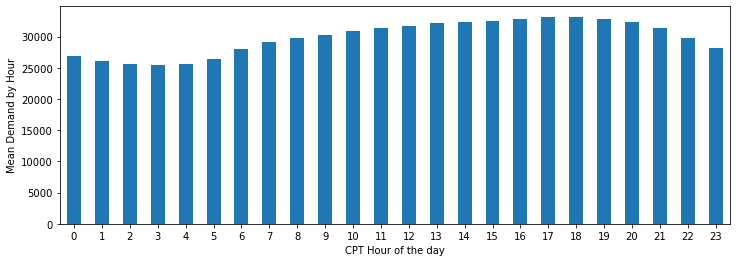

In [16]:
# from https://pandas.pydata.org/pandas-docs/dev/getting_started/intro_tutorials/09_timeseries.html
# which has other good tips

import matplotlib.pyplot as plt
fig, axs = plt.subplots(figsize=(12, 4))
demand_df.groupby(demand_df["HourBeginCPT"].dt.hour)["SPP"].mean().plot(
    kind='bar', rot=0, ax=axs
)
plt.xlabel("CPT Hour of the day");  # custom x label using matplotlib
plt.ylabel("Mean Demand by Hour");


## The oringal analysis predicted total daily demand, not total hourly demand. 

To compare with the orignal, I'll sum to the daily level too and save that




In [17]:
# this didn't work; I need to truncate the hour to the day level before the group by 
# demand_df.groupby(['HourBeginUTC'])['SPP'].sum().reset_index()

# maybe use The resample() method is similar to a groupby operation:

#    it provides a time-based grouping, by using a string (e.g. M, 5H,…) that defines the target frequency

#    it requires an aggregation function such as mean, max,…

# this still doesn't work: 
# daily_sum = demand_df.resample("M").sum()


In [18]:
# but I sure can cheat with SQLite: https://pythonspeed.com/articles/indexing-pandas-sqlite/
import sqlite3
con=sqlite3.connect("")
demand_df.to_sql('demand_df', con, if_exists='replace', index=False)

daily_demand_df=pd.read_sql("""
select datetime( HourBeginCPT, \'start of day\') as day, 
sum(SPP) as sum_spp_load
from demand_df
group by datetime( HourBeginCPT, \'start of day\')
""", con)
daily_demand_df['day'] = pd.to_datetime(daily_demand_df.day)

daily_demand_df.to_csv('dataframes/daily_demand_df.csv', compression='infer')
daily_demand_df.to_pickle('dataframes/daily_demand_df.pickle.gz', compression='infer')

daily_demand_df

# todo:  replace this with one line of Pandas

,day,sum_spp_load
0,2015-10-01,502184.942993
1,2015-10-02,612695.032412
2,2015-10-03,566229.834662
3,2015-10-04,552166.723416
4,2015-10-05,596751.461994
...,...,...
1549,2019-12-28,648146.557000
1550,2019-12-29,661993.471000
1551,2019-12-30,752393.427000
1552,2019-12-31,746139.564000


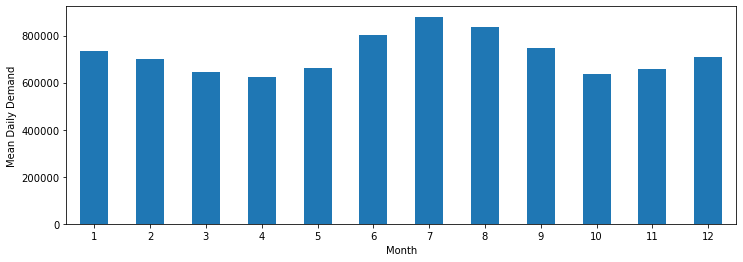

In [19]:
# from https://pandas.pydata.org/pandas-docs/dev/getting_started/intro_tutorials/09_timeseries.html
# which has other good tips

import matplotlib.pyplot as plt
fig, axs = plt.subplots(figsize=(12, 4))
daily_demand_df.groupby(daily_demand_df["day"].dt.month)["sum_spp_load"].mean().plot(
    kind='bar', rot=0, ax=axs
)
plt.xlabel("Month");  # custom x label using matplotlib
plt.ylabel("Mean Daily Demand");


## WAUE started 10/1/2015 06:00. 

So we need to either drop rows before then, or feed another weather station into the model.  We probably have enough data wihout those values before 10/1/2015. 




# Now look for weather station data

In [20]:
stations_to_load = [
    'USW00013967',  # Oklahoma City OK
    'USW00013996',  # Topeka KS 
    'USW00023047',  # Amarillo TX
    'USW00013968',  # Tulsa OK
    'USW00014939',  # Lincoln NE 
    'USW00024011',  # Bismark ND
]

# todo:  get the same station list that operations uses?

sourceurl = "https://www.ncei.noaa.gov/data/global-historical-climatology-network-daily/access/%s.csv"

for station in stations_to_load: 
    absolute_url = sourceurl%station
    save_file = downloads_dir + station + ".csv"

    if os.path.exists(save_file) == False: 
        print ("Trying to retrieve " + absolute_url + " to " + save_file, end=' ... ', flush=True)
        urllib.request.urlretrieve(absolute_url, save_file)
        print ("done")
    else:
        print (save_file + " already downloaded")
    

downloads/USW00013967.csv already downloaded
downloads/USW00013996.csv already downloaded
downloads/USW00023047.csv already downloaded
downloads/USW00013968.csv already downloaded
downloads/USW00014939.csv already downloaded
downloads/USW00024011.csv already downloaded


In [21]:
try: 
    del raw_weather_df
except: 
    pass

for stations in stations_to_load:
    save_file = downloads_dir + stations + ".csv"
    print ("reading " + save_file)
    df = pd.read_csv(save_file, low_memory=False,  parse_dates=["DATE"]) 
    
    # trim here such that DATE is greater or equal to our first load year
    df = df.loc[(df['DATE'] >= pd.to_datetime(years_to_load[0]))]
    
    try: 
        raw_weather_df = raw_weather_df.append(df)  
    except: 
        raw_weather_df = df

reading downloads/USW00013967.csv
reading downloads/USW00013996.csv
reading downloads/USW00023047.csv
reading downloads/USW00013968.csv
reading downloads/USW00014939.csv
reading downloads/USW00024011.csv


In [22]:
raw_weather_df.columns

Index(['STATION', 'DATE', 'LATITUDE', 'LONGITUDE', 'ELEVATION', 'NAME', 'PRCP',
       'PRCP_ATTRIBUTES', 'SNOW', 'SNOW_ATTRIBUTES',
       ...
       'FRTH', 'FRTH_ATTRIBUTES', 'GAHT', 'GAHT_ATTRIBUTES', 'WSFI',
       'WSFI_ATTRIBUTES', 'TOBS', 'TOBS_ATTRIBUTES', 'WDFI',
       'WDFI_ATTRIBUTES'],
      dtype='object', length=118)

In [23]:
raw_weather_df.groupby(['STATION']).size()

STATION
USW00013967    2482
USW00013968    2483
USW00013996    2483
USW00014939    2483
USW00023047    2483
USW00024011    2483
dtype: int64

In [24]:
raw_weather_df[['TMAX', 'TMIN', 'TAVG']].describe()

,TMAX,TMIN,TAVG
count,14886.000000,14885.000000,14897.000000
mean,201.541583,70.767081,135.313016
std,117.516589,111.155057,111.380996
min,-249.000000,-360.000000,-294.000000
25%,122.000000,-10.000000,54.000000
50%,222.000000,78.000000,148.000000
75%,300.000000,167.000000,231.000000
max,433.000000,283.000000,338.000000


## Extract DATE as a timestamp, and TMIN/TMAX as degrees C

Also choose here which attributes to keep. The old analysis only used "heating degree days" and "cooling degree days", which was calcuated as difference of (tmax+tmin)/2 from 65F.  

# Todo: reference old analysis? Where did notion of HDD/CDD come from?


In [25]:

weather_df = raw_weather_df[['STATION', 'DATE', 'TMIN', 'TMAX', 'TAVG']].dropna(subset=['TMIN'])

weather_df['DATE'] = pd.to_datetime(weather_df.DATE)
weather_df['TMIN'] /= 10.0 # convert from 1/10th of degrees C to degrees C
weather_df['TMAX'] /= 10.0
weather_df['TAVG'] /= 10.0

# convert degrees C to degrees F to calculate HDD around 65.0 degrees F
#   todo:  need reference for HDD/CDD formula
def c_to_f(x): 
    return (x * 9.0 / 5.0 + 32.0)

# add old analysis values of HDD and CDD
weather_df['HDD'] = weather_df['TAVG'].apply(lambda x: c_to_f(x) - 65.0 if c_to_f(x) > 65.0 else 0)  
weather_df['CDD'] = weather_df['TAVG'].apply(lambda x: 65.0 - c_to_f(x) if c_to_f(x) < 65.0 else 0)  

weather_df.sort_values(by='DATE', inplace=True, ignore_index=True)

weather_df.sample(n=20)

,STATION,DATE,TMIN,TMAX,TAVG,HDD,CDD
3605,USW00023047,2016-08-23,19.4,34.4,25.1,12.18,0.00
6548,USW00013967,2017-12-27,-7.7,-2.7,-5.6,0.00,43.08
13307,USW00013996,2021-01-27,-5.5,-2.1,-4.0,0.00,40.20
11343,USW00014939,2020-03-05,1.1,12.8,10.0,0.00,15.00
11702,USW00013996,2020-05-04,10.6,17.2,15.2,0.00,5.64
4569,USW00023047,2017-01-31,-1.6,22.2,9.3,0.00,16.26
4642,USW00013967,2017-02-12,7.2,20.0,14.8,0.00,6.36
5399,USW00013967,2017-06-18,21.1,27.2,24.9,11.82,0.00
11199,USW00013996,2020-02-10,-5.5,7.8,0.1,0.00,32.82
10841,USW00023047,2019-12-13,-1.6,17.2,7.2,0.00,20.04


In [26]:
weather_df.describe()
# This is what the old analysis used the average of TMIN,TMAX as TAVG.
# Use it because all stations have it
# weather_df['TAVG'] = (weather_df['TMIN'] + weather_df['TMAX']) / 2.0

,TMIN,TMAX,TAVG,HDD,CDD
count,14885.000000,14885.000000,14885.000000,14885.000000,14885.000000
mean,7.076708,20.154431,13.529714,4.347845,12.994359
std,11.115506,11.752007,11.141715,6.519793,15.706569
min,-36.000000,-24.900000,-29.400000,0.000000,0.000000
25%,-1.000000,12.200000,5.400000,0.000000,0.000000
50%,7.800000,22.200000,14.800000,0.000000,6.360000
75%,16.700000,30.000000,23.100000,8.580000,23.280000
max,28.300000,43.300000,33.800000,27.840000,85.920000


## Plot weather TAVG over time to make sure it looks OK - are degrees right? Are seasons reasonable? 

<AxesSubplot:xlabel='DATE'>

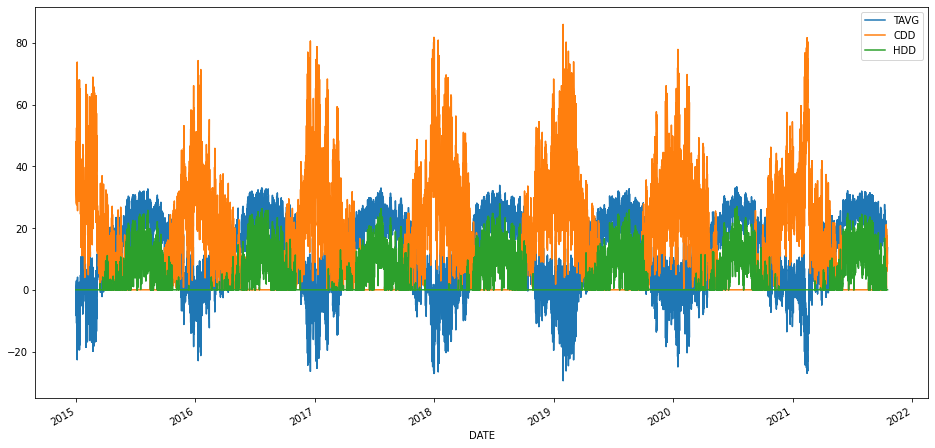

In [27]:
# todo: have one plot per station, add trendlines
weather_df[['DATE', 'TAVG', 'CDD', 'HDD']].set_index('DATE').sort_index().plot(figsize=(16,8))

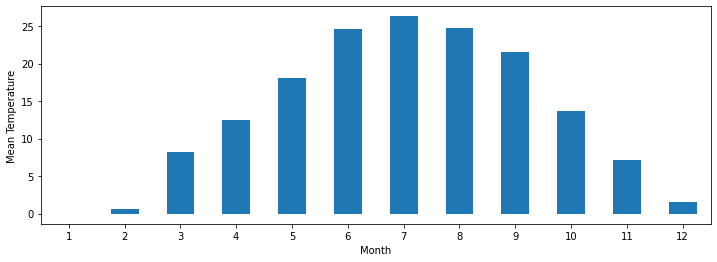

In [28]:
# from https://pandas.pydata.org/pandas-docs/dev/getting_started/intro_tutorials/09_timeseries.html
# which has other good tips

import matplotlib.pyplot as plt
fig, axs = plt.subplots(figsize=(12, 4))
weather_df.groupby(weather_df["DATE"].dt.month)["TAVG"].mean().plot(
    kind='bar', rot=0, ax=axs
)
plt.xlabel("Month");  # custom x label using matplotlib
plt.ylabel("Mean Temperature");


In [29]:

weather_df.head()

,STATION,DATE,TMIN,TMAX,TAVG,HDD,CDD
0,USW00013967,2015-01-01,-4.3,1.1,-2.7,0.0,37.86
1,USW00024011,2015-01-01,-4.3,-1.0,-3.2,0.0,38.76
2,USW00014939,2015-01-01,-13.2,1.7,-8.3,0.0,47.94
3,USW00023047,2015-01-01,-8.2,-2.7,-6.8,0.0,45.24
4,USW00013996,2015-01-01,-8.2,2.2,-5.0,0.0,42.00


In [30]:
# save for later
weather_df.to_csv('dataframes/weather_df.csv', compression="infer")
weather_df.to_pickle('dataframes/weather_df.pickle.gz', compression="infer")


# Get list of holidays on which people might demand less power

using https://github.com/dr-prodigy/python-holidays


In [31]:
from datetime import date
# installed via "conda install holidays"
import holidays
from datetime import datetime

# ignore the days people still go to work:  MLK, Wash, Columb, Veterans; load is probably unchanged these days
# alternatively: one-hot encode these days
us_holidays = holidays.UnitedStates()

holiday_list = []

for date, name in sorted(holidays.US(state='OK', years=[int(i) for i in years_to_load]).items()):
    if name not in ("Martin Luther King Jr. Day", 
                    "Washington's Birthday", 
                    "Veterans Day (Observed)",
                    "Veterans Day",
                    "Columbus Day",
                   ):
          holiday_list.append([date, name])

# many people don't work Christmas Eve; add that?
holiday_list.append([datetime.strptime('2015-12-24', '%Y-%m-%d').date(), 'Christmas Eve'])
holiday_list.append([datetime.strptime('2016-12-24', '%Y-%m-%d').date(), 'Christmas Eve'])
holiday_list.append([datetime.strptime('2017-12-24', '%Y-%m-%d').date(), 'Christmas Eve'])
holiday_list.append([datetime.strptime('2018-12-24', '%Y-%m-%d').date(), 'Christmas Eve'])
holiday_list.append([datetime.strptime('2019-12-24', '%Y-%m-%d').date(), 'Christmas Eve'])
            
holiday_df = pd.DataFrame(holiday_list, columns = ['date', 'holiday']).sort_values('date')


holiday_df

,date,holiday
0,2015-01-01,New Year's Day
1,2015-05-25,Memorial Day
2,2015-07-03,Independence Day (Observed)
3,2015-07-04,Independence Day
4,2015-09-07,Labor Day
5,2015-11-26,Thanksgiving
6,2015-11-27,Day After Thanksgiving
38,2015-12-24,Christmas Eve
7,2015-12-25,Christmas Day
8,2016-01-01,New Year's Day


In [32]:
# save the holiday df
holiday_df.to_csv('dataframes/holiday_df.csv', compression="infer")
holiday_df.to_pickle('dataframes/holiday_df.pickle.gz', compression="infer")
